In [224]:
from typing import List
import getpass
import numpy as np
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator
from qiskit.circuit import Parameter, ControlledGate
from qiskit.circuit.library import UGate, CUGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from matplotlib import pyplot as plt

In [226]:
try:
    service = QiskitRuntimeService(channel='ibm_cloud')
except Exception:
    QiskitRuntimeService.save_account(channel='ibm_cloud', token=getpass.getpass('Enter IBM Quantum token'), overwrite=True)
    service = QiskitRuntimeService(channel='ibm_cloud')

In [227]:
backend = "ibmq_qasm_simulator"

In [182]:
n = 16

In [183]:
def b_num(num: int) -> str:
    return f"{num:b}"

def is_power_of_two(num) -> bool:
    b = b_num(num)
    return b.startswith("1") and (b[1:] == "0" * (len(b) - 1))

def n_qubits() -> int:
    pixels = n ** 2
    assert is_power_of_two(pixels)
    b = b_num(pixels)
    return len(b) - 1

def scale_parameter(value: int, upper_limit: int=255) -> float:
    assert 0 <= value <= upper_limit
    return 2 * np.pi * (value / upper_limit)

In [184]:
n_qubits()

8

In [185]:
def generate_gates(img: np.ndarray) -> List[CUGate | ControlledGate]:
    shape = (img.shape[0] * img.shape[1], )
    scaled = list(map(scale_parameter, img.reshape(shape)))
    for state in range(2 ** (n_qubits() - 1)):
        theta = scaled[2 * state]
        phi = scaled[2 * state + 1]
        u = UGate(theta=theta, phi=phi, lam=0).control(n_qubits() - 1, ctrl_state=state)
        yield u

In [186]:
def build_image_qc(img):
    qc = QuantumCircuit(n_qubits())
    qc.h(range(n_qubits() - 1))
    for gate in generate_gates(img):
        qc.append(gate, range(n_qubits()))
    return qc

In [187]:
def create_random_image() -> np.ndarray:
    return np.rint(np.random.random((n, n, 1)) * 255).astype(np.uint8)

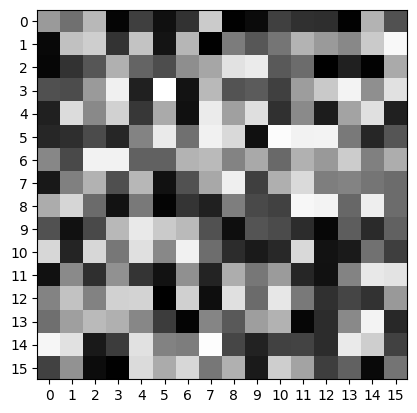

In [188]:
image = create_random_image()
plt.imshow(image, cmap="gray")
plt.xticks(np.arange(n), np.arange(n))
plt.yticks(np.arange(n), np.arange(n))
plt.show()

In [189]:
image_qc = build_image_qc(image)

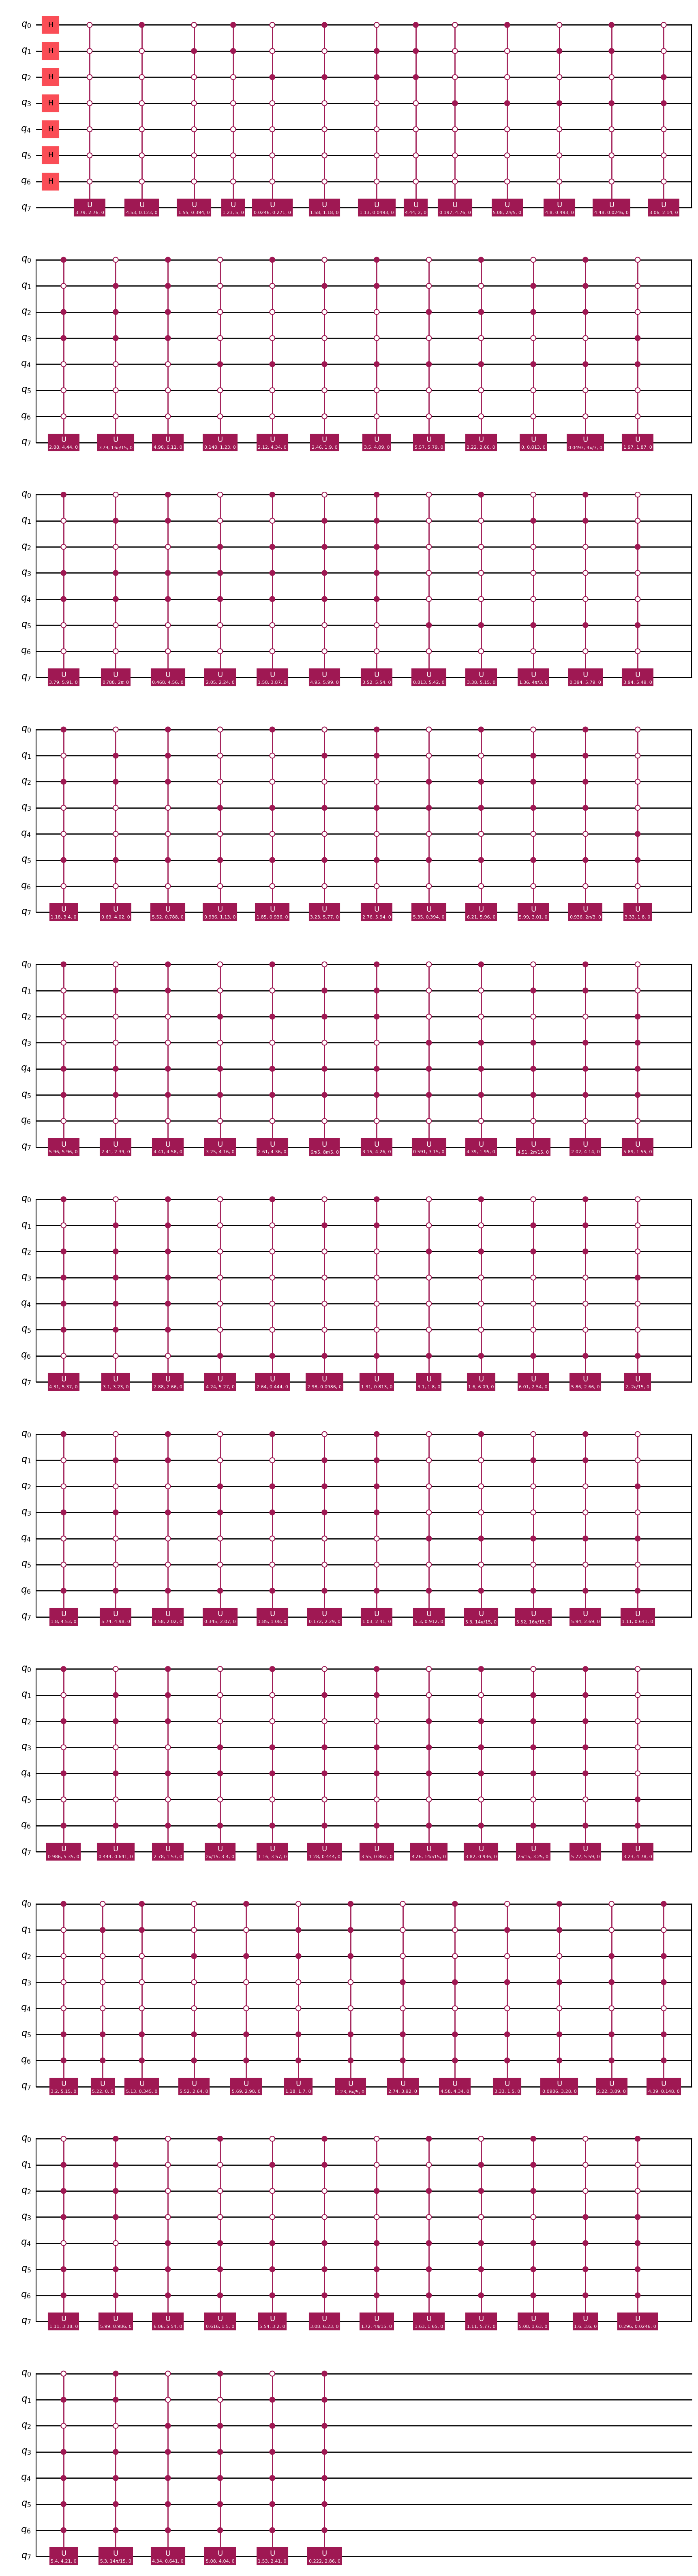

In [190]:
image_qc.draw("mpl", style="iqp")

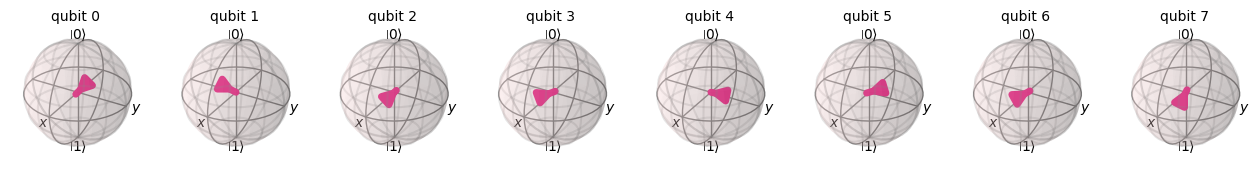

In [191]:
sv = Statevector(image_qc)
plot_bloch_multivector(sv)

In [192]:
def plot_random_image_state():
    img = create_random_image()
    img_qc = build_image_qc(img)
    my_sv = Statevector(img_qc)
    return plot_bloch_multivector(my_sv)

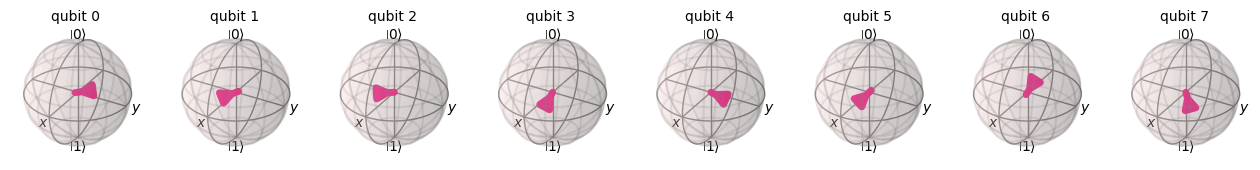

In [193]:
plot_random_image_state()

In [194]:
def plot_image_state(img):
    img_qc = build_image_qc(img)
    my_sv = Statevector(img_qc)
    return plot_bloch_multivector(my_sv)

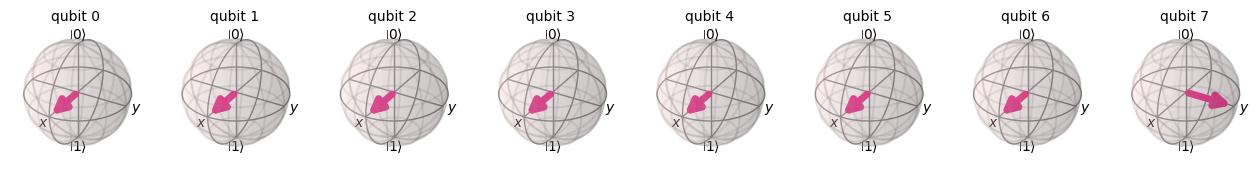

In [197]:
plot_image_state(np.ones((n, n, 1)) * 64)

In [232]:
options = Options()
options.simulator.seed_simulator = 42
options.execution.shots = 1000
options.optimization_level = 0 # no optimization
options.resilience_level = 0 # no error mitigation
observable = SparsePauliOp("XYZXYZZZ")

In [240]:
# image_qc = build_image_qc(create_random_image())
with Session(service=service, backend=backend) as session:
    estimator = Estimator(session=session)
    print(f"Result: {estimator.run(image_qc, observable).result()}")

Result: EstimatorResult(values=array([0.079]), metadata=[{'variance': 0.993759, 'shots': 4000}])
